# Predicting Price with Size, Location, and Neighborhood

In [1]:
import warnings


import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [14]:
def wrangle(filepath):
     # Read CSV file into Dataframe
    df_dt = pd.read_csv(filepath)
    
    # Drop features with high null counts
    df_dt.drop(columns=["Curb Cut", "Horizontal Enlrgmt", "Vertical Enlrgmt"], inplace=True)
    
    # Remove NAN Value
    df_dt.dropna(inplace=True)
    
    # Transform 'Initial Cost from object to float
    df_dt['Initial Cost'] = df_dt['Initial Cost'].apply(lambda x: float(x.replace('$','').replace(',','')))
    
    df_dt.drop(['Block','Bin #','Community - Board',
               'Fully Permitted','Enlargement SQ Footage',
               'Job Description','House #','Job #','Lot',
               'Street Name','Job Type'
               ],axis = 1, inplace = True
              )

    
    
    return df_dt

In [15]:
df_dt = wrangle(r"C:\Users\sanus\Desktop\DS\web\apartment_cost_list.csv")
print(df_dt.info())
df_dt.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14823 entries, 1 to 19610
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Borough               14823 non-null  object 
 1   Initial Cost          14823 non-null  float64
 2   Proposed Zoning Sqft  14823 non-null  int64  
 3   Zoning Dist1          14823 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 579.0+ KB
None


,Borough,Initial Cost,Proposed Zoning Sqft,Zoning Dist1
1,MANHATTAN,85000.0,0,R8B
2,BROOKLYN,60000.0,0,R6
4,BROOKLYN,40000.0,0,C4-3


In [16]:
df_dt.isnull().sum()

Borough                 0
Initial Cost            0
Proposed Zoning Sqft    0
Zoning Dist1            0
dtype: int64

In [18]:
# Check your work
assert len(df_dt) == 14823, f"`df` has the wrong number of rows: {len(df_dt)}"
assert df_dt.shape[1] <= 17, f"`df` has too many columns: {df_dt.shape[1]}"

In [19]:
df_dt.select_dtypes("object").nunique()

Borough           5
Zoning Dist1    139
dtype: int64

In [20]:
df_dt.select_dtypes("object").head()

,Borough,Zoning Dist1
1,MANHATTAN,R8B
2,BROOKLYN,R6
4,BROOKLYN,C4-3
5,BROOKLYN,R6
6,BROOKLYN,R6


<AxesSubplot:>

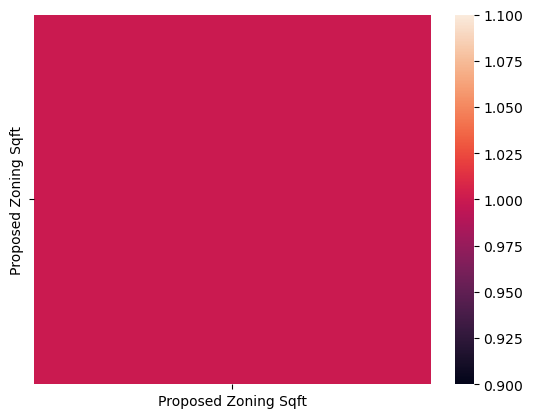

In [23]:
# Plot a correlation heatmap
corr = df_dt.select_dtypes("number").drop(columns="Initial Cost").corr()
sns.heatmap(corr)

# Split Data

In [25]:
target = "Initial Cost"
features = ["Borough", "Proposed Zoning Sqft", "Zoning Dist1"]
y_train = df_dt[target]
X_train = df_dt[features]

In [26]:
# Check your work
assert X_train.shape == (14823, 3), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (14823,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model
# Baseline

In [27]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 59641.91
Baseline MAE: 13246.892749315202


In [28]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    #LinearRegression()
    Ridge()   
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Borough', 'Zoning Dist1'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [29]:
# Check your work
check_is_fitted(model[-1])

# Evaluate

In [30]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 13236.590147483717


In [31]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 145
[-5067.38187189 -1407.98267232  5517.99951791 -1485.95884076
  2443.32386706]


In [32]:
feature_names = model.named_steps["onehotencoder"].get_feature_names() 
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 145
['Borough_MANHATTAN', 'Borough_BROOKLYN', 'Borough_BRONX', 'Borough_QUEENS', 'Borough_STATEN ISLAND']


In [33]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

Borough_MANHATTAN       -5067.381872
Borough_BROOKLYN        -1407.982672
Borough_BRONX            5517.999518
Borough_QUEENS          -1485.958841
Borough_STATEN ISLAND    2443.323867
dtype: float64

In [34]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 62661.76
+ (-5067.38 * Borough_MANHATTAN)
+ (-1407.98 * Borough_BROOKLYN)
+ (5518.0 * Borough_BRONX)
+ (-1485.96 * Borough_QUEENS)
+ (2443.32 * Borough_STATEN ISLAND)
+ (0.0 * Proposed Zoning Sqft)
+ (322.41 * Zoning Dist1_R8B)
+ (-217.26 * Zoning Dist1_R6)
+ (-3239.36 * Zoning Dist1_C4-3)
+ (-709.93 * Zoning Dist1_R6B)
+ (-2804.24 * Zoning Dist1_R5)
+ (229.85 * Zoning Dist1_R8)
+ (8343.35 * Zoning Dist1_R9A)
+ (5157.7 * Zoning Dist1_C1-5)
+ (4238.22 * Zoning Dist1_R10)
+ (-831.02 * Zoning Dist1_C2-3)
+ (6337.55 * Zoning Dist1_C5-1)
+ (-25.88 * Zoning Dist1_R8A)
+ (4223.68 * Zoning Dist1_R10A)
+ (796.27 * Zoning Dist1_R10-)
+ (1101.65 * Zoning Dist1_M1-6)
+ (1638.72 * Zoning Dist1_C4-5)
+ (1658.37 * Zoning Dist1_C1-8X)
+ (995.44 * Zoning Dist1_R7-2)
+ (-2070.18 * Zoning Dist1_R6A)
+ (-40.14 * Zoning Dist1_M1-1)
+ (-780.68 * Zoning Dist1_R7A)
+ (-7112.38 * Zoning Dist1_R7-1)
+ (891.64 * Zoning Dist1_R7B)
+ (-1849.84 * Zoning Dist1_C1-6)
+ (2996.95 * Zoning Dist1_C6-4)
+ (-1652.1

# Communicate Results

In [50]:
def make_prediction(area, lat, neighborhood):
    data = {
        "Proposed Zoning Sqft":area,
        "Zoning Dist1": lat,
        "Borough": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [51]:
make_prediction(110, 15.45, "BROOKLYN")

'Predicted apartment price: $-493446.03'